## Densenet121 Test

In [30]:
import os
import glob
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.models import EfficientNet_B0_Weights
from PIL import Image


Load Data and Model

In [31]:
label_map = {
    'real': 0,
    'fake': 1
}

def load_image_paths_labels_and_difficulty(real_dir, fake_dir):
    image_paths, labels, difficulties = [], [], []

    # Real images
    real_images = glob.glob(os.path.join(real_dir, "*.jpg"))
    image_paths.extend(real_images)
    labels.extend([label_map['real']] * len(real_images))
    difficulties.extend(['real'] * len(real_images))

    # Fake images 
    fake_images = glob.glob(os.path.join(fake_dir, "*.jpg"))
    for img_path in fake_images:
        basename = os.path.basename(img_path)
        if basename.startswith('easy'):
            diff = 'easy'
        elif basename.startswith('mid'):
            diff = 'mid'
        elif basename.startswith('hard'):
            diff = 'hard'
        else:
            diff = 'fake'
        image_paths.append(img_path)
        labels.append(label_map['fake'])
        difficulties.append(diff)

    return image_paths, labels, difficulties

# Load data
## NOTE: Change these paths to your own directories

real_dir = "/Users/chrishaleas/cv/real_and_fake_face/training_real"
fake_dir = "/Users/chrishaleas/cv/real_and_fake_face/training_fake"
paths, labels, diffs = load_image_paths_labels_and_difficulty(real_dir, fake_dir)


In [32]:
paths, labels, diffs = load_image_paths_labels_and_difficulty(real_dir, fake_dir)
train_paths, val_paths, train_labels, val_labels, train_diffs, val_diffs = \
    train_test_split(paths, labels, diffs, test_size=0.25, random_state=42, stratify=labels)

In [34]:
class FaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    def __len__(self): return len(self.image_paths)
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models import DenseNet121_Weights

weights = DenseNet121_Weights.DEFAULT
transform = weights.transforms()

train_dataset = FaceDataset(train_paths, train_labels, transform=transform)
val_dataset = FaceDataset(val_paths, val_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = models.densenet121(weights=weights)

model.classifier = nn.Linear(model.classifier.in_features, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)



Train Model

In [37]:
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/10, Loss: 0.6424
Epoch 2/10, Loss: 0.3151
Epoch 3/10, Loss: 0.1231
Epoch 4/10, Loss: 0.0596
Epoch 5/10, Loss: 0.0367
Epoch 6/10, Loss: 0.0286
Epoch 7/10, Loss: 0.0356
Epoch 8/10, Loss: 0.0358
Epoch 9/10, Loss: 0.0707
Epoch 10/10, Loss: 0.0510


Evaluate Model

In [38]:
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for imgs, lbls in val_loader:
        imgs = imgs.to(device)
        out = model(imgs)
        preds = out.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(lbls.numpy())

acc = accuracy_score(all_true, all_preds)
print(f"Binary Validation Accuracy: {acc:.4f}")

correct_counts = {d: 0 for d in ['easy','mid','hard','real']}
total_counts = {d: 0 for d in ['easy','mid','hard','real']}
for true, pred, diff in zip(all_true, all_preds, val_diffs):
    total_counts[diff] += 1
    if true == pred:
        correct_counts[diff] += 1

print("Per-difficulty results:")
for d in ['real','easy','mid','hard']:
    print(f"{d.capitalize()}: {correct_counts[d]}/{total_counts[d]} correct")


Binary Validation Accuracy: 0.7104
Per-difficulty results:
Real: 181/271 correct
Easy: 27/51 correct
Mid: 103/128 correct
Hard: 52/61 correct


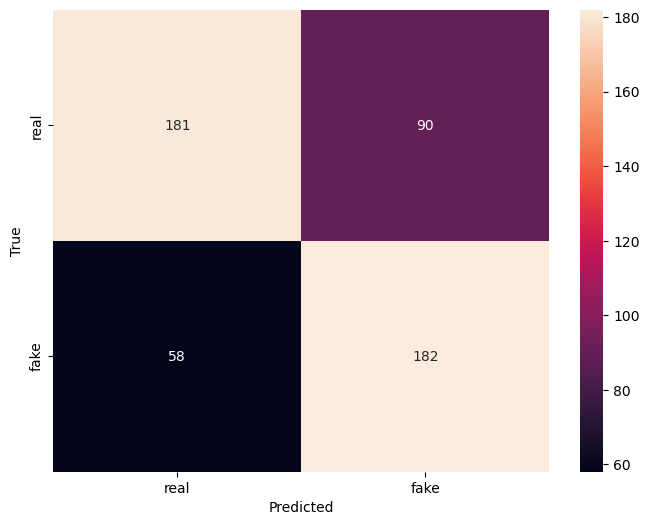

In [39]:
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['real','fake'], yticklabels=['real','fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [40]:
from sklearn.metrics import classification_report

print(classification_report(all_true, all_preds, target_names=['real', 'fake']))

              precision    recall  f1-score   support

        real       0.76      0.67      0.71       271
        fake       0.67      0.76      0.71       240

    accuracy                           0.71       511
   macro avg       0.71      0.71      0.71       511
weighted avg       0.72      0.71      0.71       511



Adversarial Attacks

In [41]:
# ATTACK FUNCTIONS
import numpy as np

def apply_gaussian_noise(img, mean=0.0, std=0.3):
    img = transforms.ToTensor()(img)
    noise = torch.randn_like(img) * std + mean
    noisy_img = img + noise
    noisy_img = torch.clamp(noisy_img, 0., 1.)
    return transforms.ToPILImage()(noisy_img)

#color shift attack
def apply_color_shift(img, shift_value=0.5):
    img = transforms.ToTensor()(img)
    color_shift = torch.tensor([shift_value, shift_value, shift_value]).view(3, 1, 1)
    shifted_img = img + color_shift
    shifted_img = torch.clamp(shifted_img, 0., 1.)
    return transforms.ToPILImage()(shifted_img)

# apply a black patch to the image 
def apply_black_patch(img, patch_size=190):
    img = transforms.ToTensor()(img)
    _, h, w = img.size()
    x = np.random.randint(0, w - patch_size)
    y = np.random.randint(0, h - patch_size)
    img[:, y:y+patch_size, x:x+patch_size] = 0
    return transforms.ToPILImage()(img)


In [42]:
# ATTACK DATASETS
class AttackFaceDataset(Dataset):
    def __init__(self, image_paths, labels, attack_fn=None, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.attack_fn = attack_fn
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        
        if self.attack_fn:
            image = self.attack_fn(image)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Create attack datasets
gaussian_dataset = AttackFaceDataset(val_paths, val_labels, attack_fn=apply_gaussian_noise, transform=transform)
color_shift_dataset = AttackFaceDataset(val_paths, val_labels, attack_fn=apply_color_shift, transform=transform)
black_box_dataset = AttackFaceDataset(val_paths, val_labels, attack_fn= apply_black_patch, transform=transform)


In [43]:
# ATTACK DATALOADERS
gaussian_loader = DataLoader(gaussian_dataset, batch_size=32, shuffle=False)
color_shift_loader = DataLoader(color_shift_dataset, batch_size=32, shuffle=False)
black_box_loader = DataLoader(black_box_dataset, batch_size=32, shuffle=False)


Evaluate Model after Adversarial Attacks

In [44]:
# EVALUATE FUNCTION
def evaluate_attack(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    return acc


In [45]:
# EVALUATE UNDER DIFFERENT ATTACKS
clean_acc = evaluate_attack(model, val_loader, device)
gaussian_acc = evaluate_attack(model, gaussian_loader, device)
color_patch_acc = evaluate_attack(model, color_shift_loader, device)
black_box_acc = evaluate_attack(model, black_box_loader, device)

# PRINT RESULTS
print(f"Validation Accuracy (Clean): {clean_acc:.4f}")
print(f"Validation Accuracy (Gaussian Noise Attack): {gaussian_acc:.4f}")
print(f"Validation Accuracy (Color Shift Attack): {color_patch_acc:.4f}")
print(f"Validation Accuracy (Black Patch Attack): {black_box_acc:.4f}")

Validation Accuracy (Clean): 0.7104
Validation Accuracy (Gaussian Noise Attack): 0.6184
Validation Accuracy (Color Shift Attack): 0.6262
Validation Accuracy (Black Patch Attack): 0.6517


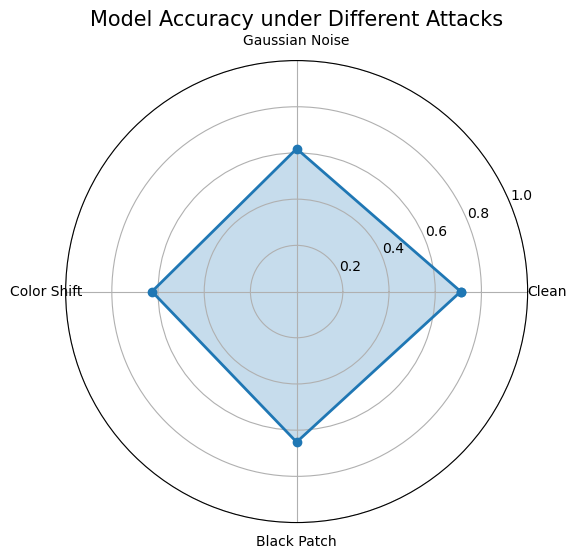

In [51]:
# SPIDERWEB PLOT
import matplotlib.pyplot as plt
import numpy as np

labels = ['Clean', 'Gaussian Noise', 'Color Shift', 'Black Patch']
accuracies = [clean_acc, gaussian_acc, color_patch_acc, black_box_acc]

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
accuracies += accuracies[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
ax.plot(angles, accuracies, 'o-', linewidth=2)
ax.fill(angles, accuracies, alpha=0.25)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0, 1)
plt.title('Model Accuracy under Different Attacks', size=15)
plt.show()
